In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve, auc)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
import seaborn as sns
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import f1_score
import random
import time

RANDOM_STATE = 61
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
sns.set()
plt.rcParams["figure.figsize"] = (8,5)

In [2]:
CLEANED_PATH = Path("/kaggle/input/cleaned-flights-data-of-aeolus/cleaned_flight_data.csv")
if not CLEANED_PATH.exists():
    raise FileNotFoundError(f"Cleaned file not found: {CLEANED_PATH}. Run preprocessing first or update the path.")

df = pd.read_csv(CLEANED_PATH)
df = df.head(10000)
print("Loaded cleaned data:", df.shape)
display(df.head(3))

Loaded cleaned data: (10000, 12)


,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,FL_MONTH,FL_DAY,FL_WEEKDAY,CRS_DEP_TIME_hour,DEP_TIME_hour,TAXI_OUT,WHEELS_OFF_hour,Delayed
0,0,4814.0,158,89,1,1,0,12,12,31.0,13,0
1,0,5181.0,158,89,1,1,0,17,17,32.0,17,0
2,0,5329.0,158,89,1,1,0,7,7,15.0,7,0


In [3]:
if "Delayed" not in df.columns:
    raise KeyError("Column 'Delayed' not found in cleaned dataset.")

X = df.drop(columns=["Delayed"])
y = df["Delayed"]

In [4]:
print("Features:", X.columns.tolist())
print("Class distribution:", y.value_counts().to_dict())

Features: ['OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'FL_MONTH', 'FL_DAY', 'FL_WEEKDAY', 'CRS_DEP_TIME_hour', 'DEP_TIME_hour', 'TAXI_OUT', 'WHEELS_OFF_hour']
Class distribution: {0: 8294, 1: 1706}


In [5]:
RANDOM_STATE = 61
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class dist:", y_train.value_counts(normalize=True).round(3).to_dict())

Train shape: (8000, 11) Test shape: (2000, 11)
Train class dist: {0: 0.829, 1: 0.171}


In [6]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train, y_train, test_size=0.20, stratify=y_train, random_state=RANDOM_STATE
)
print("Tuning split -> train_small:", X_train_small.shape, "val:", X_val.shape)


Tuning split -> train_small: (6400, 11) val: (1600, 11)


In [7]:
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
# scoring = "f1"   

In [8]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

In [9]:
rf_param_dist = {
    "n_estimators": [100, 200, 400],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": [None, "balanced"]
}

n_iter_rf = 12  # number of random configs to try
best_score = -1.0
best_params_rf = None
best_rf_model = None

print("\n--- Random search (single validation) for RandomForest ---")
start_time = time.time()
for i, params in enumerate(ParameterSampler(rf_param_dist, n_iter=n_iter_rf, random_state=RANDOM_STATE)):
    # build model with sampled params
    model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, **params)
    model.fit(X_train_small, y_train_small)
    y_val_pred = model.predict(X_val)
    score = f1_score(y_val, y_val_pred)
    print(f"[RF] iter {i+1}/{n_iter_rf}  f1_val={score:.4f} params={params}")
    if score > best_score:
        best_score = score
        best_params_rf = params
        best_rf_model = model

elapsed = time.time() - start_time
print(f"Best RF val F1 = {best_score:.4f}")
print("Best RF params:", best_params_rf)
print(f"RF tuning time: {elapsed:.1f}s")

# Refit best RF on the entire original X_train (train_small + val) for final evaluation
best_rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, **best_params_rf)
best_rf.fit(X_train, y_train)
print("Refitted best RF on full training data.")



--- Random search (single validation) for RandomForest ---
[RF] iter 1/12  f1_val=0.5521 params={'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'class_weight': None}
[RF] iter 2/12  f1_val=0.7372 params={'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None, 'class_weight': 'balanced'}
[RF] iter 3/12  f1_val=0.7338 params={'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'class_weight': 'balanced'}
[RF] iter 4/12  f1_val=0.7403 params={'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None, 'class_weight': 'balanced'}
[RF] iter 5/12  f1_val=0.7273 params={'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10, 'class_weight': 'balanced'}
[RF] iter 6/12  f1_val=0.6898 params={'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30, 'class_weight': None}
[RF] iter 7/12  f1_val=0.6853 params=

In [10]:
# rf_param_dist = {
#     "n_estimators": [100, 200, 400],
#     "max_depth": [None, 10, 20, 30],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
#     "class_weight": [None, "balanced"]
# }

# rf_search = RandomizedSearchCV(
#     rf,
#     param_distributions=rf_param_dist,
#     n_iter=12,
#     # scoring=scoring,
#     # cv=cv,
#     random_state=RANDOM_STATE,
#     verbose=1,
#     n_jobs=-1,
#     return_train_score=False
# )

# print("\n--- Running RandomizedSearchCV for RandomForest ---")
# rf_search.fit(X_train, y_train)
# print("RF best params:", rf_search.best_params_)
# print("RF best CV score (f1):", rf_search.best_score_.round(4))
# best_rf = rf_search.best_estimator_

In [11]:
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]

In [12]:
rf_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_rf),
    "precision": precision_score(y_test, y_pred_rf),
    "recall": recall_score(y_test, y_pred_rf),
    "f1": f1_score(y_test, y_pred_rf),
    "roc_auc": roc_auc_score(y_test, y_proba_rf)
}
print("\nRandom Forest Test metrics:")
for k,v in rf_metrics.items():
    print(f"{k}: {v:.4f}")


Random Forest Test metrics:
accuracy: 0.9205
precision: 0.7880
recall: 0.7302
f1: 0.7580
roc_auc: 0.9450


In [13]:
print("\nRF Classification Report:")
print(classification_report(y_test, y_pred_rf))


RF Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1659
           1       0.79      0.73      0.76       341

    accuracy                           0.92      2000
   macro avg       0.87      0.84      0.86      2000
weighted avg       0.92      0.92      0.92      2000



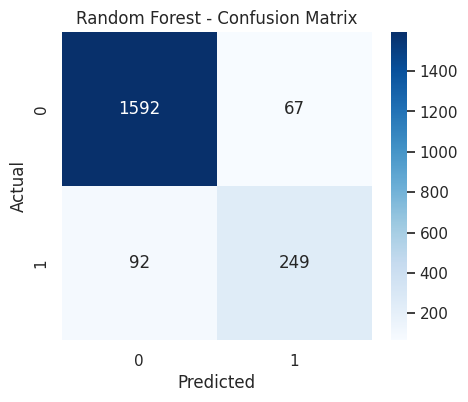

In [14]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [15]:
# neg = (y_train == 0).sum()
# pos = (y_train == 1).sum()
# scale_pos_weight = neg / pos
# print(f"\nXGBoost scale_pos_weight (neg/pos) = {scale_pos_weight:.3f}")

In [16]:
# xgb = XGBClassifier(
#     objective="binary:logistic",
#     use_label_encoder=False,
#     eval_metric="logloss",
#     random_state=RANDOM_STATE,
    
#     # GPU settings
#     tree_method="gpu_hist",
#     predictor="gpu_predictor",
# )


In [17]:
# xgb_param_dist = {
#     "n_estimators": [100, 200, 400],
#     "max_depth": [3, 6, 10],
#     "learning_rate": [0.01, 0.05, 0.1, 0.2],
#     "subsample": [0.6, 0.8, 1.0],
#     "colsample_bytree": [0.5, 0.8, 1.0],
#     "scale_pos_weight": [scale_pos_weight, 1.0]
# }

In [18]:
# xgb_search = RandomizedSearchCV(
#     xgb,
#     param_distributions=xgb_param_dist,
#     n_iter=16,
#     scoring=scoring,
#     cv=cv,
#     random_state=RANDOM_STATE,
#     verbose=1,
#     n_jobs=-1,
#     return_train_score=False
# )

In [19]:
# -------------------------
# Random search for XGBoost (single validation)
# -------------------------
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = float(neg) / float(pos)
print(f"\nXGBoost scale_pos_weight (neg/pos) = {scale_pos_weight:.3f}")

xgb_param_dist = {
    "n_estimators": [100, 200, 400],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.5, 0.8, 1.0],
    "scale_pos_weight": [scale_pos_weight, 1.0]
}

n_iter_xgb = 16
best_score = -1.0
best_params_xgb = None
best_xgb_model = None

print("\n--- Random search (single validation) for XGBoost ---")
start_time = time.time()
for i, params in enumerate(ParameterSampler(xgb_param_dist, n_iter=n_iter_xgb, random_state=RANDOM_STATE)):
    # construct XGB with GPU options if available (you can remove tree_method for CPU-only)
    model = XGBClassifier(
        objective="binary:logistic",
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        tree_method="hist", 
        device="cuda",
        **params
    )
    # For small data, disable verbose
    model.fit(X_train_small, y_train_small, verbose=False)
    y_val_pred = model.predict(X_val)
    score = f1_score(y_val, y_val_pred)
    print(f"[XGB] iter {i+1}/{n_iter_xgb}  f1_val={score:.4f} params={params}")
    if score > best_score:
        best_score = score
        best_params_xgb = params
        best_xgb_model = model

elapsed = time.time() - start_time
print(f"Best XGB val F1 = {best_score:.4f}")
print("Best XGB params:", best_params_xgb)
print(f"XGB tuning time: {elapsed:.1f}s")

# Refit best XGBoost on the entire original X_train for final evaluation
best_xgb = XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    tree_method="hist",    
    predictor="gpu_predictor",
    **best_params_xgb
)
best_xgb.fit(X_train, y_train)
print("Refitted best XGBoost on full training data.")


XGBoost scale_pos_weight (neg/pos) = 4.861

--- Random search (single validation) for XGBoost ---
[XGB] iter 1/16  f1_val=0.7773 params={'subsample': 1.0, 'scale_pos_weight': 1.0, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
[XGB] iter 2/16  f1_val=0.4945 params={'subsample': 0.6, 'scale_pos_weight': 1.0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
[XGB] iter 3/16  f1_val=0.7340 params={'subsample': 1.0, 'scale_pos_weight': 4.86080586080586, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
[XGB] iter 4/16  f1_val=0.7546 params={'subsample': 0.8, 'scale_pos_weight': 1.0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
[XGB] iter 5/16  f1_val=0.7171 params={'subsample': 1.0, 'scale_pos_weight': 1.0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
[XGB] iter 6/16  f1_val=0.7845 params={'subsample': 1

In [20]:
# print("\n--- Running RandomizedSearchCV for XGBoost ---")
# xgb_search.fit(X_train, y_train)
# print("XGB best params:", xgb_search.best_params_)
# print("XGB best CV score (f1):", xgb_search.best_score_.round(4))

In [21]:
# best_xgb = xgb_search.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:,1]

In [22]:
xgb_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_xgb),
    "precision": precision_score(y_test, y_pred_xgb),
    "recall": recall_score(y_test, y_pred_xgb),
    "f1": f1_score(y_test, y_pred_xgb),
    "roc_auc": roc_auc_score(y_test, y_proba_xgb)
}
print("\nXGBoost Test metrics:")
for k,v in xgb_metrics.items():
    print(f"{k}: {v:.4f}")


XGBoost Test metrics:
accuracy: 0.9130
precision: 0.7072
recall: 0.8358
f1: 0.7661
roc_auc: 0.9466


In [23]:
print("\nXGB Classification Report:")
print(classification_report(y_test, y_pred_xgb))


XGB Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1659
           1       0.71      0.84      0.77       341

    accuracy                           0.91      2000
   macro avg       0.84      0.88      0.86      2000
weighted avg       0.92      0.91      0.92      2000



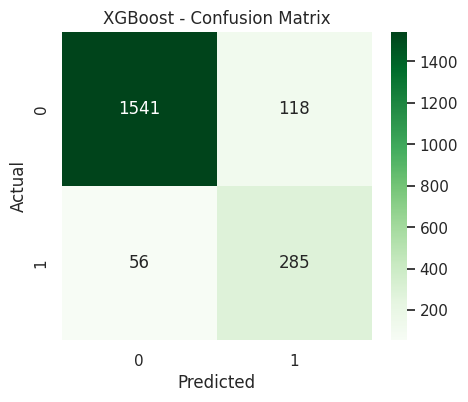

In [24]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens")
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [25]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

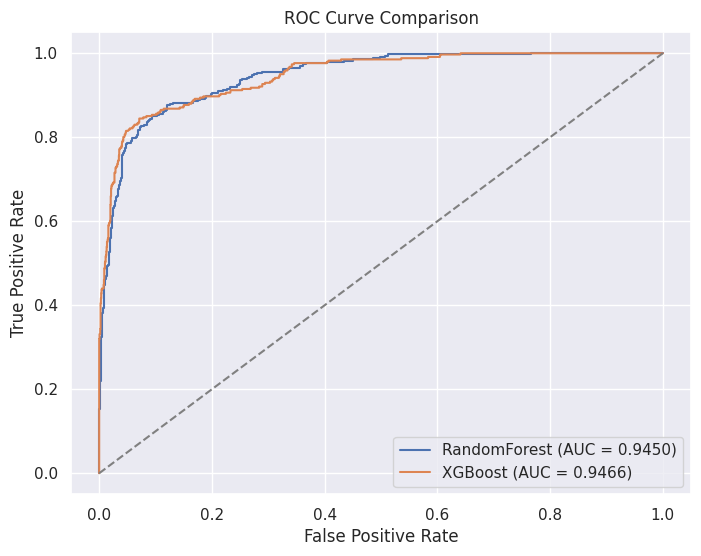

In [26]:
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC = {rf_metrics['roc_auc']:.4f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {xgb_metrics['roc_auc']:.4f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

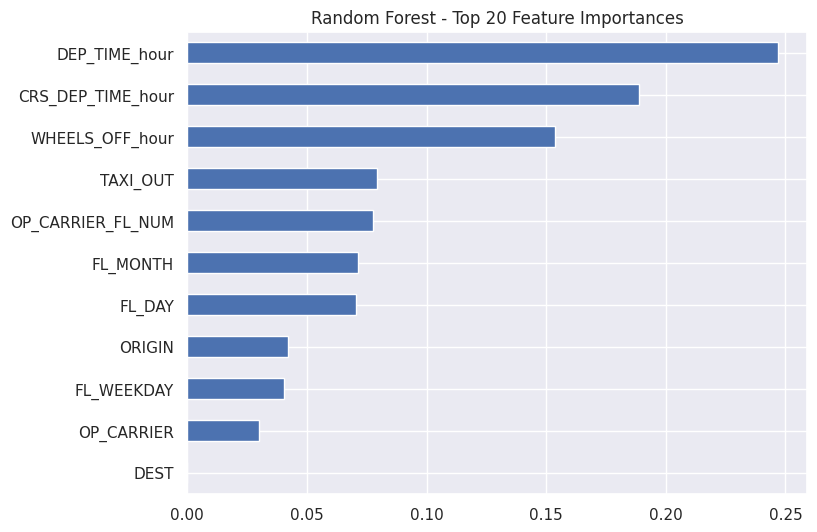

In [27]:
rf_importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
rf_importances.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Random Forest - Top 20 Feature Importances")
plt.show()

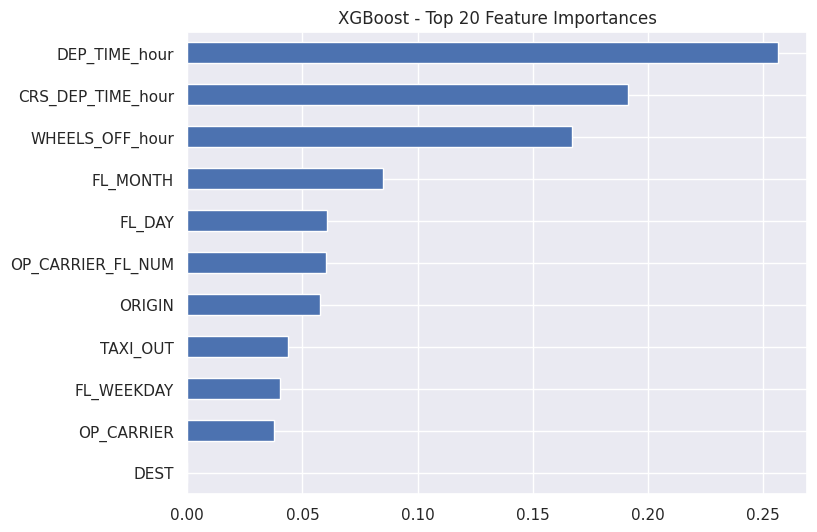

In [28]:
try:
    xgb_importances = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(8,6))
    xgb_importances.head(20).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("XGBoost - Top 20 Feature Importances")
    plt.show()
except Exception as e:
    print("Could not plot XGBoost importances:", e)

In [29]:
out_dir = Path("/kaggle/working/models")
out_dir.mkdir(exist_ok=True)
joblib.dump(best_rf, out_dir / "best_random_forest.pkl")
joblib.dump(best_xgb, out_dir / "best_xgboost.pkl")
print("Saved models to:", out_dir)

Saved models to: /kaggle/working/models


In [30]:
comp_df = pd.DataFrame([rf_metrics, xgb_metrics], index=["RandomForest","XGBoost"]).T
comp_df.to_csv("/kaggle/working/model_comparison_metrics.csv")
print("Saved metrics to /kaggle/working/model_comparison_metrics.csv")
display(comp_df)

Saved metrics to /kaggle/working/model_comparison_metrics.csv


,RandomForest,XGBoost
accuracy,0.920500,0.913000
precision,0.787975,0.707196
recall,0.730205,0.835777
f1,0.757991,0.766129
roc_auc,0.945036,0.946635


In [31]:
print("\nSummary (Test set):")
print("RandomForest:", rf_metrics)
print("XGBoost:", xgb_metrics)


Summary (Test set):
RandomForest: {'accuracy': 0.9205, 'precision': 0.7879746835443038, 'recall': 0.7302052785923754, 'f1': 0.7579908675799087, 'roc_auc': 0.9450363166165533}
XGBoost: {'accuracy': 0.913, 'precision': 0.707196029776675, 'recall': 0.8357771260997068, 'f1': 0.7661290322580645, 'roc_auc': 0.9466351669291644}


In [32]:
print("\nRandomForest classification report:\n")
print(classification_report(y_test, y_pred_rf))
print("\nXGBoost classification report:\n")
print(classification_report(y_test, y_pred_xgb))


RandomForest classification report:

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1659
           1       0.79      0.73      0.76       341

    accuracy                           0.92      2000
   macro avg       0.87      0.84      0.86      2000
weighted avg       0.92      0.92      0.92      2000


XGBoost classification report:

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1659
           1       0.71      0.84      0.77       341

    accuracy                           0.91      2000
   macro avg       0.84      0.88      0.86      2000
weighted avg       0.92      0.91      0.92      2000

